In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# prompt: cek versi tensorflow

tf.__version__


'2.18.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/Coba_sandi/data-final.zip /content/
!unzip -q /content/data-final.zip -d /content/data-final

In [ ]:
path = '/content/data-final'

TRAIN_DIR = os.path.join(path, 'train')
TEST_DIR = os.path.join(path, 'test')
VAL_DIR = os.path.join(path, 'val')

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 17260 images belonging to 12 classes.
Found 4315 images belonging to 12 classes.
Found 5393 images belonging to 12 classes.


In [ ]:
# Simpan ke Google Drive (jika pakai Colab)
save_dir = '/content/drive/MyDrive/Coba_sandi/model_dense95'
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, 'model_checkpoint.h5')

# Callback untuk stop jika akurasi training & val >= 90%
class StopWhenTrainValAccAbove90(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        train_acc = logs.get("accuracy") or logs.get("acc")
        val_acc = logs.get("val_accuracy") or logs.get("val_acc")

        if train_acc is not None and val_acc is not None:
            if train_acc >= 0.95 and val_acc >= 0.95:
                print(f"\n✅ Training dihentikan di epoch {epoch+1} karena accuracy dan val_accuracy >= 95%")
                self.model.stop_training = True

# Callback untuk menyimpan model
checkpoint_callback = ModelCheckpoint(
    filepath=model_path,
    monitor='val_accuracy',
    save_best_only=False,
    save_weights_only=False,
    verbose=1
)

callbacks_list = [
    StopWhenTrainValAccAbove90(),
    checkpoint_callback
]

# MODEL dengan input 224x224 (default DenseNet)
base_model = DenseNet121(
    input_shape=(224, 224, 3),  # Ubah dari 128x128 ke 224x224
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze awal

# Top layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(12, activation='softmax')(x)  # ganti sesuai jumlah kelas

model = Model(inputs=base_model.input, outputs=outputs)

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,334,348 (27.98 MB)

 Trainable params: 296,844 (1.13 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
class_name = list(train_generator.class_indices.keys())

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [ ]:
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=2,  # training awal
    callbacks=callbacks_list,
    class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 914ms/step - accuracy: 0.5382 - loss: 1.4356
Epoch 1: saving model to /content/drive/MyDrive/Coba_sandi/model_dense95/model_checkpoint.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - accuracy: 0.5387 - loss: 1.4339 - val_accuracy: 0.8816 - val_loss: 0.3734
Epoch 2/2
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 856ms/step - accuracy: 0.8164 - loss: 0.5905
Epoch 2: saving model to /content/drive/MyDrive/Coba_sandi/model_dense95/model_checkpoint.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 247s 916ms/step - accuracy: 0.8165 - loss: 0.5904 - val_accuracy: 0.9043 - val_loss: 0.3072


In [ ]:
# 🔧 FINE-TUNING
# =======================
# Unfreeze base model
base_model.trainable = True

# Hanya buka 50 layer terakhir
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Re-compile model untuk fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-4),  # learning rate kecil saat fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks_list,
    class_weight=class_weights  # jika dataset tidak seimbang
)

Epoch 1/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - accuracy: 0.8406 - loss: 0.5334
Epoch 1: saving model to /content/drive/MyDrive/Coba_sandi/model_dense95/model_checkpoint.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - accuracy: 0.8407 - loss: 0.5331 - val_accuracy: 0.9235 - val_loss: 0.2523
Epoch 2/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 862ms/step - accuracy: 0.8859 - loss: 0.3663
Epoch 2: saving model to /content/drive/MyDrive/Coba_sandi/model_dense95/model_checkpoint.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 249s 923ms/step - accuracy: 0.8859 - loss: 0.3663 - val_accuracy: 0.9356 - val_loss: 0.2196
Epoch 3/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - accuracy: 0.9118 - loss: 0.2928
Epoch 3: saving model to /content/drive/MyDrive/Coba_sandi/model_dense95/model_checkpoint.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 264s 932ms/step - accuracy: 0.9118 - loss: 0.2928 - val_accuracy: 0.9390 - val_loss: 0.2009
Epoch 4/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 856ms/step - accuracy: 0.9194 - loss: 0.2600
Epoch 4: saving model to /content/drive/MyDrive/Coba_sandi/model_dense95/model_checkpoint.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 258s 916ms/step - accuracy: 0.9194 - loss: 0.2600 - val_accuracy: 0.9395 - val_loss: 0.1996
Epoch 5/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 861ms/step - accuracy: 0.9260 - loss: 0.2338
Epoch 5: saving model to /content/drive/MyDrive/Coba_sandi/model_dense95/model_checkpoint.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 264s 922ms/step - accuracy: 0.9260 - loss: 0.2338 - val_accuracy: 0.9469 - val_loss: 0.1871
Epoch 6/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 862ms/step - accuracy: 0.9348 - loss: 0.2080
Epoch 6: saving model to /content/drive/MyDrive/Coba_sandi/model_dense95/model_checkpoint.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 263s 924ms/step - accuracy: 0.9348 - loss: 0.2080 - val_accuracy: 0.9504 - val_loss: 0.1753
Epoch 7/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 865ms/step - accuracy: 0.9428 - loss: 0.1834
Epoch 7: saving model to /content/drive/MyDrive/Coba_sandi/model_dense95/model_checkpoint.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 250s 926ms/step - accuracy: 0.9428 - loss: 0.1834 - val_accuracy: 0.9539 - val_loss: 0.1666
Epoch 8/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.9473 - loss: 0.1633
Epoch 8: saving model to /content/drive/MyDrive/Coba_sandi/model_dense95/model_checkpoint.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 260s 921ms/step - accuracy: 0.9473 - loss: 0.1633 - val_accuracy: 0.9569 - val_loss: 0.1545
Epoch 9/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - accuracy: 0.9550 - loss: 0.1339
✅ Training dihentikan di epoch 9 karena accuracy dan val_accuracy >= 95%

Epoch 9: saving model to /content/drive/MyDrive/Coba_sandi/model_dense95/model_checkpoint.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 248s 919ms/step - accuracy: 0.9550 - loss: 0.1339 - val_accuracy: 0.9583 - val_loss: 0.1569


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 48s 436ms/step
🔍 Classification Report:
                   precision    recall  f1-score   support

        Alas Kaki       0.99      0.99      0.99       467
             Daun       0.98      0.99      0.99       397
             Kaca       0.93      0.93      0.93       473
     Kain Pakaian       1.00      0.99      0.99       449
           Kardus       0.90      0.96      0.93       443
             Kayu       0.97      0.95      0.96       442
           Kertas       0.91      0.90      0.90       462
            Logam       0.91      0.96      0.93       451
          Plastik       0.92      0.89      0.91       438
Sampah Elektronik       0.98      0.99      0.99       461
   Sampah makanan       0.97      0.98      0.98       463
        Sterofoam       0.96      0.89      0.92       447

         accuracy                           0.95      5393
        macro avg       0.95      0.95      0.95      5393
     weighted avg       0.95      0.95      0.

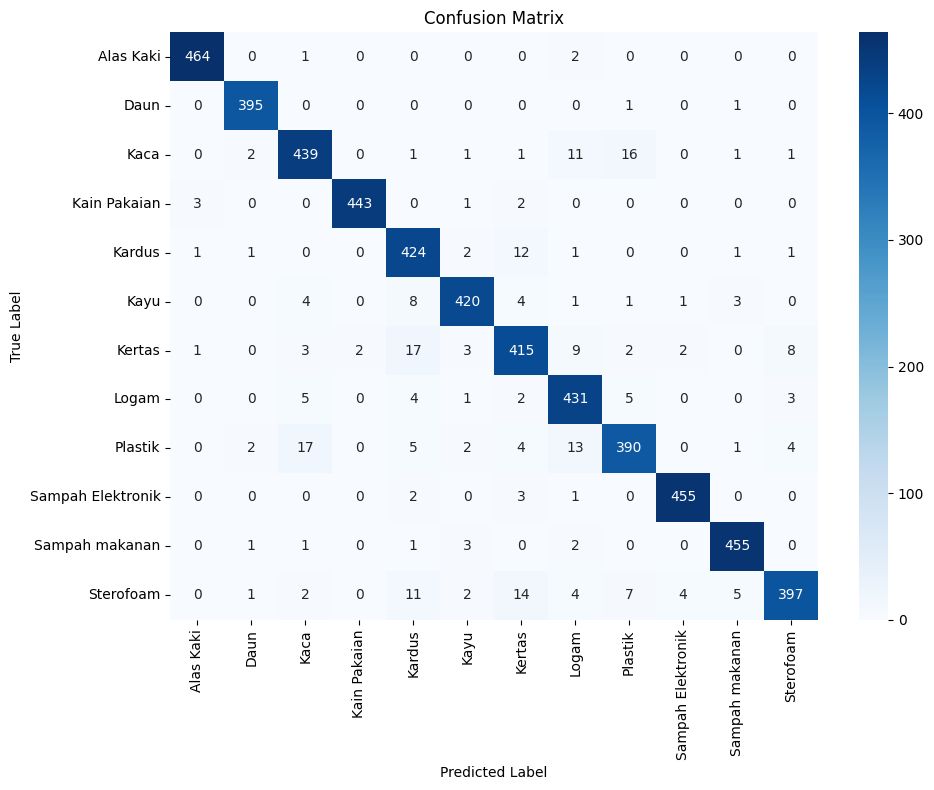

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === PREDIKSI DATA TEST ===
# Pastikan test_generator tidak memiliki shuffle=True saat dibuat
pred_probs = model.predict(test_generator)
y_pred = np.argmax(pred_probs, axis=1)  # Prediksi kelas (int)

# Label asli
y_true = test_generator.classes  # label ground truth (int)

# === NAMA KELAS ===
class_names = list(test_generator.class_indices.keys())

# === CLASSIFICATION REPORT ===
print("🔍 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
import io
import json
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input
import ipywidgets as widgets
from IPython.display import display

# Mapping label
class_indices = train_generator.class_indices
class_labels = dict((v, k) for k, v in class_indices.items())

# Widget upload
upload = widgets.FileUpload(
    accept='image/*',
    multiple=False
)
display(upload)

# Fungsi inference + JSON output
def predict_to_json(uploaded_file):
    if not uploaded_file:
        print("❌ Tidak ada gambar yang diupload.")
        return

    for fname, file_info in uploaded_file.value.items():
        # Load image from uploaded bytes
        img_bytes = file_info['content']
        img = image.load_img(io.BytesIO(img_bytes), target_size=(224, 224))

        # Preprocess
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Predict
        preds = model.predict(img_array)
        pred_idx = np.argmax(preds[0])
        pred_label = class_labels[pred_idx]
        confidence = float(preds[0][pred_idx])

        # Output JSON
        result_json = {
            "class": pred_label,
            "confidence": round(confidence, 4)
        }

        print(json.dumps(result_json, indent=2))

# Jalankan saat upload terjadi
upload.observe(lambda change: predict_to_json(upload), names='value')

FileUpload(value={}, accept='image/*', description='Upload')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
{
  "class": "Kertas",
  "confidence": 1.0
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
{
  "class": "Sampah Elektronik",
  "confidence": 0.8269
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
{
  "class": "Sampah Elektronik",
  "confidence": 0.9964
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
{
  "class": "Kain Pakaian",
  "confidence": 1.0
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
{
  "class": "Sterofoam",
  "confidence": 0.9915
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
{
  "class": "Sampah Elektronik",
  "confidence": 1.0
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
{
  "class": "Alas Kaki",
  "confidence": 0.9962
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
{
  "class": "Plastik",
  "confidence": 0.9999
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
{
  "class": "Kardus",
  "confidence": 1.0
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
{
  "class": "Logam",
  "confidence": 0.9821
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
{
  "class": "Plastik",
  "confidence": 0.6601
}


In [ ]:
model.save('/content/drive/MyDrive/Coba_sandi/model_dense95/model_dense.keras')  # Keras native format

model.save('/content/drive/MyDrive/Coba_sandi/model_dense95/model_dense.h5')

# menyimpan dengan format pickle



In [ ]:
import pickle

# Path tempat Anda ingin menyimpan model pickle di Google Drive
pickle_save_path = '/content/drive/MyDrive/Coba_sandi/model_dense95/model_dense.pkl'

# Simpan model menggunakan pickle
with open(pickle_save_path, 'wb') as f:
    pickle.dump(model, f)

print(f"✅ Model akhir berhasil disimpan dalam format pickle di: {pickle_save_path}")

✅ Model akhir berhasil disimpan dalam format pickle di: /content/drive/MyDrive/Coba_sandi/model_dense95/model_dense.pkl


In [ ]:
import json

# Ambil class indices dari train_generator
label_map = train_generator.class_indices

# Balik mappingnya agar index -> label (untuk prediksi)
index_to_label = {v: k for k, v in label_map.items()}

# Simpan ke JSON
label_json_path = '/content/drive/MyDrive/Coba_sandi/model_dense95/label_map.json'
with open(label_json_path, 'w') as f:
    json.dump(index_to_label, f, indent=4)

print(f"✅ Label mapping disimpan di: {label_json_path}")

✅ Label mapping disimpan di: /content/drive/MyDrive/Coba_sandi/model_dense95/label_map.json
